In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import math

In [2]:
def box3d(n):
    x = []
    y = []
    z = []
    for i, val in enumerate([-0.5, -0.5, 0, 0.5, 0.5],1):
        x = np.concatenate((x, val*np.ones(n)))
        y = np.concatenate((y,np.linspace(-0.5,0.5,n)))
        z = np.concatenate((z,(-1)**i*val*np.ones(n)))
        x1 = np.concatenate((x,x))
        x2 = np.concatenate((x1,y))
        y1 = np.concatenate((y,z))
        y2 = np.concatenate((y1,x))
        z1 = np.concatenate((z,y))
        z2 = np.concatenate((z1,z))
        
    return np.vstack((x2, y2, z2))


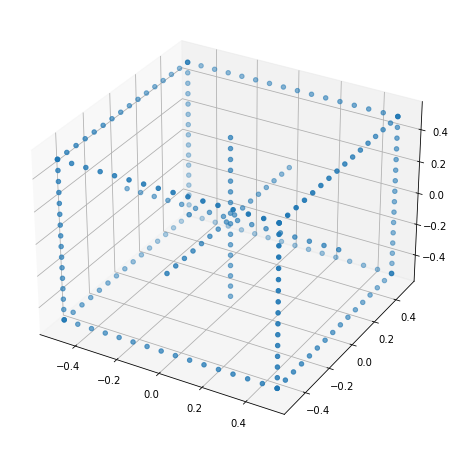

In [3]:
x, y, z = box3d(16)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')  # syntax for 3-D projection
ax.scatter3D(x, y, z)
plt.show()

In [4]:
def projectpoints(K, R, t, Q):
    Rt = np.hstack((R,t))
    Qh = np.vstack((Q,np.ones(len(Q[0]))))
    q = K@Rt@Qh
    return q[:-1]/q[-1]

# Exercise 2.1

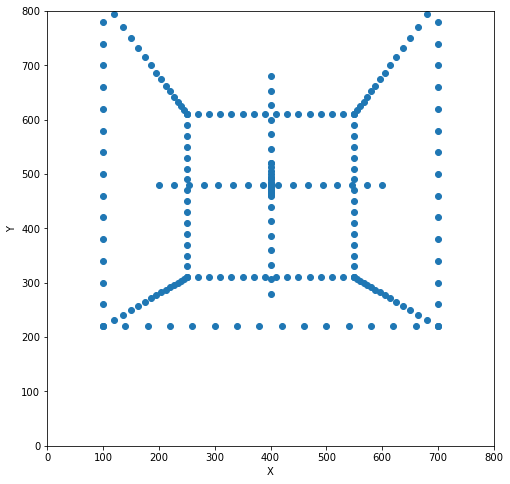

In [5]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([[0,0.2,1.5]]).T
Q = box3d(16)
q = projectpoints(K, R, t, Q)
fig = plt.figure(figsize=(8,8))
plt.scatter(q[0,:], q[1,:])
plt.xlim((0, 800))
plt.ylim((0, 800))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [6]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([[0,0.2,1.5]]).T
P1 = np.array([[-0.5,-0.5,-0.5]]).T
q1 = projectpoints(K, R, t, P1)

print(q1)

[[100.]
 [220.]]


# Exercise 2.2


In [7]:
def projectpoints_distortion(K, R, t, Q, dist):
    Rt = np.hstack((R,t))
    Qh = np.vstack((Q,np.ones(len(Q[0]))))
    pd = Rt@Qh
    pd_i = pd[:-1]/pd[-1] 
    
    pd_i2 = np.power(pd_i,2)   #calculate x^2, y^2
    r = np.sqrt(pd_i2[0]+[pd_i2[1]])   #sqrt(x^2 + y^2)
  ####delat_r = k3*r^2+k5*r^4+... 
    delat_r = 0
    for i in range(len(dist)):
        delat_r = delat_r + dist[i]*np.power(r,2*i+2)
    
    pc_i = pd_i* (delat_r+1)
    pc = np.vstack((pc_i,np.ones(len(pc_i[0]))))
    q = K @ pc
    return  q[:-1]/q[-1]

In [8]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([[0,0.2,1.5]]).T
P1 = np.array([[-0.5,-0.5,-0.5]]).T
dist = np.array([-0.2, 0, 0])  ##Barrel distortion
q2 = projectpoints_distortion(K, R, t, P1,dist)
print(q2)

[[120.4 ]
 [232.24]]


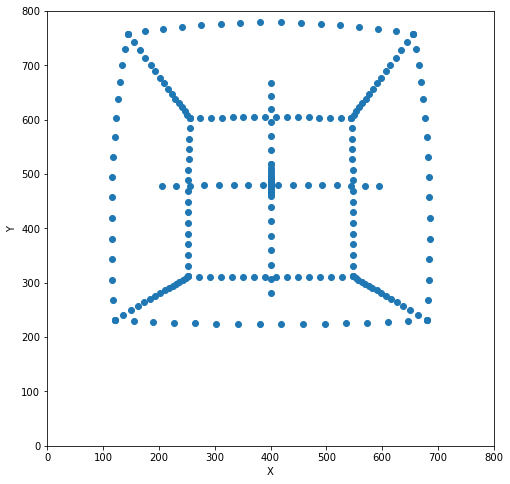

In [9]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([[0,0.2,1.5]]).T
Q = box3d(16)
dist = np.array([-0.2, 0, 0])   ##Barrel distortion
q3 = projectpoints_distortion(K, R, t, Q, dist)
fig = plt.figure(figsize=(8,8))
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(q3[0,:], q3[1,:])
plt.xlim((0, 800))
plt.ylim((0, 800))
plt.show()

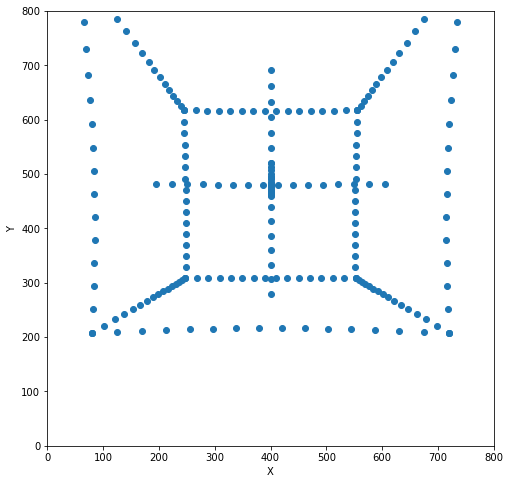

In [10]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([[0,0.2,1.5]]).T
Q = box3d(16)
dist = np.array([0.2, 0, 0])   ##Pincushion distortion
q3 = projectpoints_distortion(K, R, t, Q, dist)
fig = plt.figure(figsize=(8,8))
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(q3[0,:], q3[1,:])
plt.xlim((0, 800))
plt.ylim((0, 800))
plt.show()

# Exercise 2.3

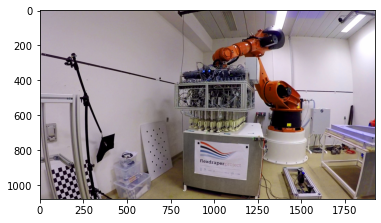

In [11]:
img = cv2.imread('gopro_robot.jpg')
im1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(im1)

# Exercise 2.4

If the figure is undistorted, the origin point coordinate is p, we could know the pixel coordinate q = K@p (we assume without rotation and transform)   
Now we know the pixel coordinate q is 0-1080, 0-1920, so we could get origin coordinate p  = inv(K)@q   
Now we have origin coordinate p    
Because the figure is distorted, so could calculate qd based on p,     
we have already know the correspond q of p, and the coorespond qd and RGB of p, 
so we could get the RGB of q from the qd

In [12]:
def undistortImage(image, K, dist):
    (height, width,d) = image.shape
    x, y = np.meshgrid(np.linspace(0,width-1,width), np.linspace(0,height-1,height))
    x = x.flatten()
    y = y.flatten()
    origin = np.vstack((x,y))     #creat origin coordinate matrix[0~1979][0~1919]
    originh = np.vstack((origin,np.ones(len(origin[0]))))
    Kinv = np.linalg.inv(K)
    p = Kinv@originh      #normalize coordinate
    pih = p[:-1]/p[-1]
    pd_i2 = np.power(pih,2)   #calculate x^2, y^2
    r = np.sqrt(pd_i2[0]+[pd_i2[1]])   #sqrt(x^2 + y^2)
    delat_r = 0
    for i in range(len(dist)):
        delat_r = delat_r + dist[i]*np.power(r,2*i+2)
    delat_r = delat_r+1
    pc_i = pih* delat_r
    pc = np.vstack((pc_i,np.ones(len(pc_i[0]))))
    q = K @ pc
    q = q[:-1]/q[-1]       #based on the origin coordinate matrix, calculate the corresponding coordinate matrix
    
    
    undistort = np.zeros(shape = (height,width))  #find the origin coordinate corrsponding tensity from image
    undistort = undistort.tolist()
    for i in range(height):
        for j in range(width):
            row = int(q[1][i*width+j])
            col = int(q[0][i*width+j])

            undistort[i][j] = list(image[row][col])
    
    return undistort

In [13]:
K = np.array([[875,0,960],[0,875,540],[0,0,1]])
k3 = -0.245031
k5 = 0.071524
k7 = -0.00994978
dist = np.array([k3,k5,k7])

undistort1 = undistortImage(im1,K, dist)

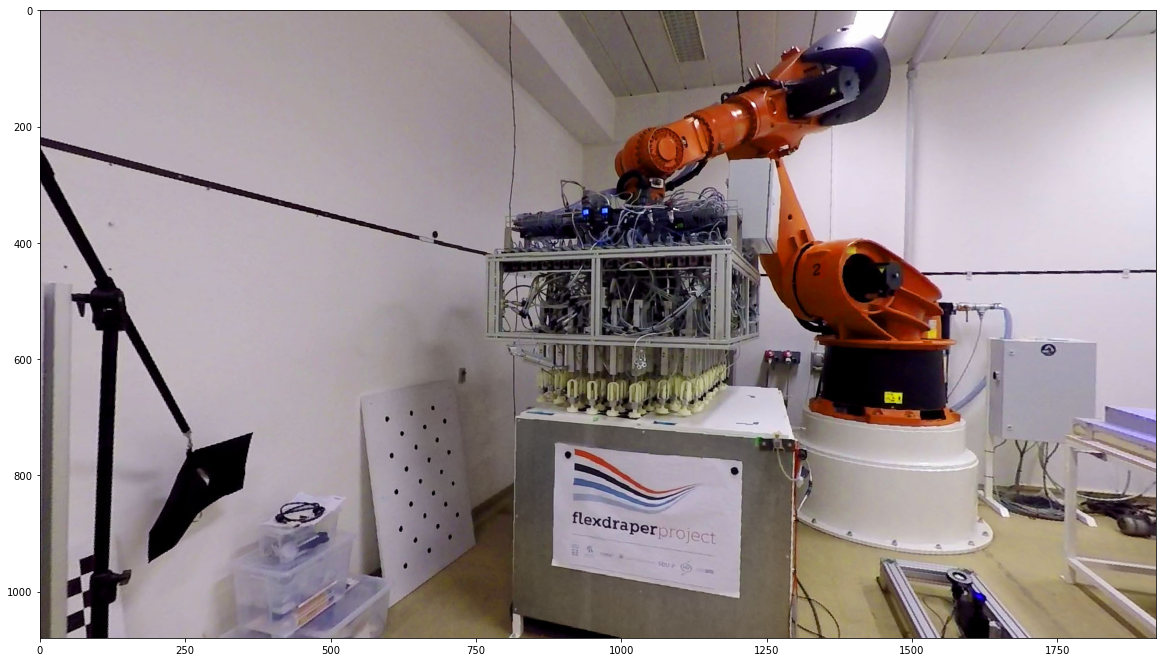

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(undistort1)

# Exercise 2.5

In [15]:
def homography(H, p):
    ph = np.vstack((p, np.ones(len(p[0]))))
    qh = H@ph
    return qh[:-1]/qh[-1]

In [16]:
p1 = np.array([[1],[1]])
p2 = np.array([[0],[3]])
p3 = np.array([[2],[3]])
p4 = np.array([[2],[4]])
H = np.array([[-2, 0, 1],[1,-2, 0],[0, 0, 3]])

In [17]:
q1 = homography(H,p1)
q2 = homography(H,p2)
q3 = homography(H,p3)
q4 = homography(H,p4)

In [18]:
print("the q1 is:\n",q1,'\n',"the q2 is:\n",q2,'\n',"the q3 is:\n",q3,'\n',"the q4 is:\n",q4)

the q1 is:
 [[-0.33333333]
 [-0.33333333]] 
 the q2 is:
 [[ 0.33333333]
 [-2.        ]] 
 the q3 is:
 [[-1.        ]
 [-1.33333333]] 
 the q4 is:
 [[-1.]
 [-2.]]


# Exercise 2.6

In [19]:
def CrossOp(p):
    px = np.array([  [0,-p[2],p[1]],[p[2],0,-p[0]],[-p[1],p[0],0]   ])
    return px

In [20]:
def hest(q1,q2):
    ###q1 = H@q2
    q1 = np.vstack((q1, np.ones(len(q1[0]))))
    q2 = np.vstack((q2, np.ones(len(q2[0]))))
    B= np.kron(q2[:,0],CrossOp(q1[:,0]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i],CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    
    _,_,vh = np.linalg.svd(B.T@B)
    H = np.reshape(vh[-1],(3,3))
    H = H.T.round(2)
    
    return H

In [21]:
Q1 = np.hstack((q1,q2,q3,q4))
Q2 = np.hstack((p1,p2,p3,p4))

In [22]:
Hhest = hest(Q1,Q2)
H = np.array([[-2, 0, 1],[1,-2, 0],[0, 0, 3]])

In [23]:
Hhest = Hhest/np.linalg.norm(Hhest,'fro')*np.linalg.norm(H,'fro') #make Hhest has same norm as H, so it will be easy for us to compare
Hhest

array([[ 2., -0., -1.],
       [-1.,  2.,  0.],
       [ 0., -0., -3.]])

# Exercise 2.7

In [24]:
def normalize2D(pi):
    pih = np.vstack((pi, np.ones(len(pi[0]))))
    m = np.mean(pih,1)
    stdd = np.std(pih,1)
    T = np.diag([1/stdd[0],1/stdd[1],1])
    T[0][2]=-m[0]/stdd[0]
    T[1][2]=-m[1]/stdd[1]
    qi = T@pih
    return qi[:-1]/qi[-1],T

In [25]:
Q1norm,_ = normalize2D(Q1)
Q2norm,_ = normalize2D(Q2)

In [26]:
print('Q1 mean:')
print(np.mean(Q1norm,1).round(2))
print('Q1 std:')
print(np.std(Q1norm,1))
print('Q2 mean:')
print(np.mean(Q2norm,1).round(2))
print('Q2 std:')
print(np.std(Q2norm,1))

Q1 mean:
[ 0. -0.]
Q1 std:
[1. 1.]
Q2 mean:
[ 0. -0.]
Q2 std:
[1. 1.]


# Exercise 2.8

In [27]:
def hestnorm(q1,q2):
    ###q1 = H@q2
    ###q1n = T1@q1   q2n = T2@q2  q1=H@q2
    ###inv(T1)@q1n = H@(inv(T2)@q2)     q1n = Hn@q2n
    ###H = inv(T1)@Hn@T2
    q1n,T1 = normalize2D(q1)
    q2n,T2 = normalize2D(q2)
    q1n = np.vstack((q1n, np.ones(len(q1[0]))))
    q2n = np.vstack((q2n, np.ones(len(q2[0]))))
#    q1n,T1 = normalize2D(q1)
#    q2n,T2 = normalize2D(q2)
    B= np.kron(q2n[:,0],CrossOp(q1n[:,0]))
    for i in range(1,len(q1n[0])):
        B_temp = np.kron(q2n[:,i],CrossOp(q1n[:,i]))
        B = np.vstack((B,B_temp))
    
    _,_,vh = np.linalg.svd(B.T@B)
    Hn = np.reshape(vh[-1],(3,3))
    H = np.linalg.inv(T1)@Hn.T@T2
    H = H.round(2)
    
    return H

In [28]:
Hhest = hestnorm(Q1,Q2)
H = np.array([[-2, 0, 1],[1,-2, 0],[0, 0, 3]])
Hhest = Hhest/np.linalg.norm(Hhest,'fro')*np.linalg.norm(H,'fro') #make Hhest has same norm as H, so it will be easy for us to compare
Hhest.round(1)

array([[ 2.,  0., -1.],
       [-1.,  2., -0.],
       [-0.,  0., -3.]])